In [37]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import phik
import matplotlib.pyplot as plt
titanic = pd.read_csv(r"..\data\Titanic-Dataset.csv")

# Ingenieria de Features

Se plantean 10 nuevos feutures que permitiran cuntificar variables no numericas, las cuales permitiran y facilitaran analisis. Se platean la siguientes:

**Title:** Es el titulo honorifico de cada pasajero.(str)

**FamiliSize:** Tamaño de la familia. (int)

**IsAlone:** 0 si viajaba solo, 1 si no.

**AgeGroup:** Se categorizó segun la edad, "Infant"(0-12) años, "Teenager" (13-18) años, "Adult" (19-64)años y "Third age" (mayor de 65 años).

**FarePerPerson:** Se encontro el costo del ticket individual.

**IsMother:** 1 si es madre, 0 si no.

**FareAboveMedian:** 1 si el precio del tiket esta por ensima de la media, 0 si no.

**FamilySurvivalID:** Agrupa a los pasajeros que compartían el billete o apellido.

**LastName:** El apellido del pasajero.

**CabinKnown:** 1 si se conoce la cabina, 0 si no.


In [38]:
#Funciones auxiliares
def get_age_group(age):
    """Asigna la edad a un grupo en epecifico

    Args:
        age (int): Edad

    Returns:
        categoria
    """
    if pd.isnull(age):
      return 'Unknown'
    elif age <= 12:
      return 'Infant'
    elif age <= 18:
      return 'Teenager'
    elif age <= 64:
      return 'Adult'
    else:
      return 'Third age'

In [39]:
titanic_procesado = titanic.copy()
titanic_procesado['Title'] = titanic_procesado['Name'].apply(lambda x: re.search(r' ([A-Za-z]+)\.', x).group(1))
titanic_procesado['FamilySize'] = titanic_procesado['SibSp'] + titanic_procesado['Parch'] + 1
titanic_procesado['IsAlone'] = (titanic_procesado['FamilySize'] == 1).astype(int)
titanic_procesado['AgeGroup'] = titanic_procesado['Age'].apply(get_age_group)
titanic_procesado['IsMother'] = ((titanic_procesado['Sex'] == 'female') &
                      (titanic_procesado['Age'] >= 16) &  # Madres más jóvenes
                      (titanic_procesado['Parch'] > 0) &
                      ((titanic_procesado['SibSp'] > 0) | (titanic_procesado['Parch'] > 1)) &  # Más evidencia familiar
                      (~titanic_procesado['Title'].isin(['Miss', 'Ms']))).astype(int)  # Excluir solteras
titanic_procesado['FareAboveMedian'] = (titanic_procesado['Fare'] > titanic_procesado['Fare'].mean()).astype(int)
titanic_procesado['FarePerPerson'] = titanic_procesado['Fare'] / (titanic_procesado.groupby('Ticket')['PassengerId'].transform('count'))
titanic_procesado['FamilySurvivalID'] = titanic_procesado['Ticket'].astype(str) + '_' + titanic_procesado['Name'].str.split(',').str[0]
titanic_procesado['LastName'] = titanic_procesado['Name'].str.split(',').str[0]
titanic_procesado['CabinKnown'] = titanic_procesado['Cabin'].notna().astype(int)

In [41]:
import phik
import pandas as pd

# Calcular correlación de cada variable con Survived
survived_corr = {}

for column in titanic_procesado.columns:
    if column != 'Survived':
        corr_value = titanic_procesado[[column, 'Survived']].phik_matrix().iloc[0, 1]
        survived_corr[column] = corr_value

# Crear DataFrame ordenado
correlation_df = pd.DataFrame.from_dict(survived_corr, orient='index', 
                                       columns=['Correlation_with_Survived'])
correlation_df = correlation_df.sort_values('Correlation_with_Survived', 
                                           ascending=False)

print("Correlación de cada variable con Survived:")
print(correlation_df)

interval columns not set, guessing: ['PassengerId', 'Survived']
interval columns not set, guessing: ['Pclass', 'Survived']
interval columns not set, guessing: ['Survived']
interval columns not set, guessing: ['Survived']
interval columns not set, guessing: ['Age', 'Survived']
interval columns not set, guessing: ['SibSp', 'Survived']
interval columns not set, guessing: ['Parch', 'Survived']
interval columns not set, guessing: ['Survived']
interval columns not set, guessing: ['Fare', 'Survived']
interval columns not set, guessing: ['Survived']
interval columns not set, guessing: ['Survived']
interval columns not set, guessing: ['Survived']
interval columns not set, guessing: ['FamilySize', 'Survived']
interval columns not set, guessing: ['IsAlone', 'Survived']
interval columns not set, guessing: ['Survived']
interval columns not set, guessing: ['IsMother', 'Survived']
interval columns not set, guessing: ['FareAboveMedian', 'Survived']
interval columns not set, guessing: ['FarePerPerson',

In [ ]:
def check_leakage(variable, target='Survived', threshold=0.7):
    """
    Detecta posible leakage si la variable tiene correlación muy alta
    y muchos valores únicos
    """
    if variable not in titanic_procesado.columns or variable == target:
        return False
        
    # Verificar que la variable tenga al menos 2 valores únicos
    if titanic_procesado[variable].nunique() < 2:
        print(f"{variable}: Solo 1 valor único → Saltar")
        return False
        
    try:
        # Calcular correlación con manejo de errores
        corr = titanic_procesado[[variable, target]].phik_matrix().iloc[0, 1]
        
        # Verificar unicidad
        uniqueness = titanic_procesado[variable].nunique() / len(titanic_procesado)
        
        # Criterio de leakage
        is_leakage = (corr > threshold) and (uniqueness > 0.5)
        
        print(f"{variable}: Corr={corr:.3f}, Unicidad={uniqueness:.3f} → {'LEAKAGE' if is_leakage else 'OK'}")
        
        return is_leakage
        
    except Exception as e:
        print(f"{variable}: Error en cálculo → {str(e)[:50]}...")
        return False

suspicious_vars = [col for col in titanic_procesado.columns if col != 'Survived']

print("Análisis de Data Leakage:")
print("=" * 50)

for var in suspicious_vars:
    check_leakage(var)

🔍 Análisis de Data Leakage:
interval columns not set, guessing: ['PassengerId', 'Survived']
PassengerId: Corr=0.141, Unicidad=1.000 → OK
interval columns not set, guessing: ['Pclass', 'Survived']
Pclass: Corr=0.205, Unicidad=0.003 → OK
interval columns not set, guessing: ['Survived']
Name: Corr=1.000, Unicidad=1.000 → LEAKAGE
interval columns not set, guessing: ['Survived']
Sex: Corr=0.750, Unicidad=0.002 → OK
interval columns not set, guessing: ['Age', 'Survived']
Age: Corr=0.203, Unicidad=0.099 → OK
interval columns not set, guessing: ['SibSp', 'Survived']
SibSp: Corr=0.176, Unicidad=0.008 → OK
interval columns not set, guessing: ['Parch', 'Survived']
Parch: Corr=0.147, Unicidad=0.008 → OK
interval columns not set, guessing: ['Survived']
Ticket: Corr=0.773, Unicidad=0.764 → LEAKAGE
interval columns not set, guessing: ['Fare', 'Survived']
Fare: Corr=0.265, Unicidad=0.278 → OK
interval columns not set, guessing: ['Survived']
Cabin: Corr=0.625, Unicidad=0.165 → OK
interval columns not s

Con este analisis evidensiamos datos que son unicos como lo son el nombre, el ticket y el FamilySurvivalID que envista que son unicos al momento de implementar un modelo de maching learning puede perjudicar la capacidad de predicción ya que memozaria patrones muy fuertes que sesgaria su elección.

In [ ]:
variables_leakage = ['Name', 'Ticket', 'FamilySurvivalID']
correlation_df = correlation_df[~correlation_df.index.isin(variables_leakage)]

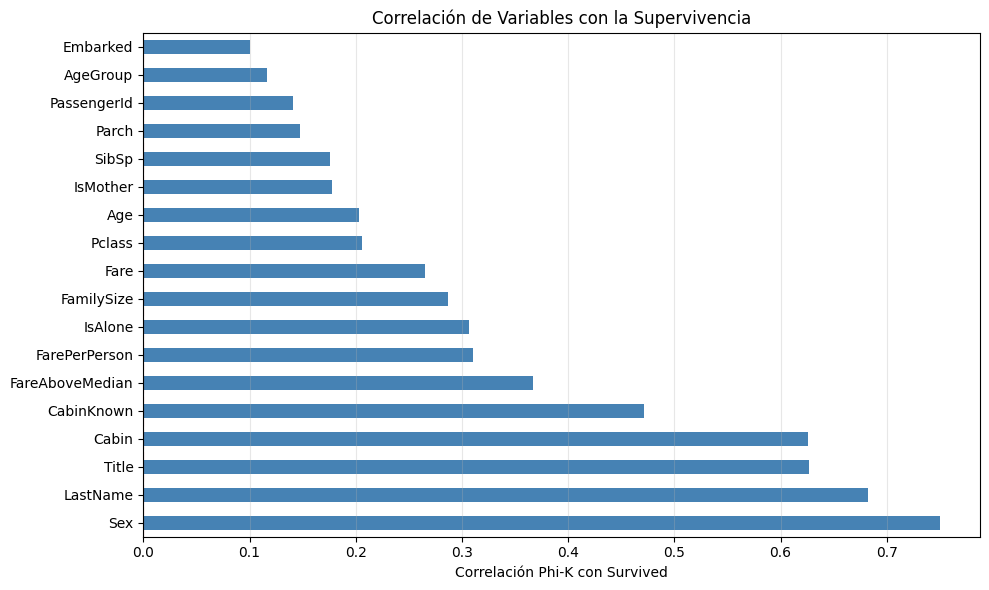

In [49]:
plt.figure(figsize=(10, 6))
correlation_df['Correlation_with_Survived'].plot(kind='barh', color='steelblue')
plt.xlabel('Correlación Phi-K con Survived')
plt.title('Correlación de Variables con la Supervivencia')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()